In [1]:
# import pprint
# import sys

# pprint.pprint(sys.path)

In [2]:
# import fundamental libraries
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import os
import sys
sys.path.append('/mnt/c/Users/44yos/RacePrediction/resnet_win5')
from os import path
import time

# preporcessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
from pickle import dump

# tesndorflow libraries
import tensorflow as tf
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras import optimizers, callbacks
from tensorflow.python.keras import backend as K

# from models import resnet
from models import transformer

# from utils import functions
from utils import create_time_series_data, smooth_label, categorical_focal_loss, order_algorithm

In [3]:
# # load data
data = pd.read_csv("../data/csv/data.csv", sep = ",")
print(data.dtypes)

race_id                        int64
race_round                     int64
ground_condition               int64
total_horse_number             int64
order                          int64
frame_number                   int64
horse_number                   int64
age                            int64
burden_weight                float64
goal_time                    float64
half_order                   float64
last_time                    float64
odds                         float64
horse_weight                 float64
pop                          float64
race_rank                      int64
distance                       int64
ground_type_ダ                  int64
ground_type_芝                  int64
circle_右                       int64
circle_左                       int64
weather_circumstance_小雨        int64
weather_circumstance_小雪        int64
weather_circumstance_晴         int64
weather_circumstance_曇         int64
weather_circumstance_雨         int64
weather_circumstance_雪         int64
p

In [4]:
data.dropna(inplace=True)
print(len(data))

217032


In [5]:
data.drop_duplicates(inplace=True)
print(len(data))

215967


In [6]:
# # adjust columns type
data['race_id'] = data['race_id'].astype(str)
data['order'] = data['order'].astype(str)

In [7]:
# delete race day information
data.drop(["horse_number", "half_order", "goal_time" ,"last_time", "horse_weight", "horse_weight_dif", "frame_number","pop"], axis = 1, inplace=True)
# "race_round",
data.reset_index(drop=True, inplace=True)

In [8]:
# print(data.dtypes)

In [3]:
# # standarlization 
# no_scale_data = data[['race_id','order']]
# scale_columns = data.drop(['race_id','order'], axis=1).columns.values
# standard_scale = StandardScaler()
# data = pd.DataFrame(standard_scale.fit_transform(data[scale_columns]))

# # PCA
# pca = PCA()
# data = pd.DataFrame(pca.fit_transform(data))
# contrb_rate = pd.DataFrame(pca.explained_variance_ratio_, columns = ['rate'])
# sum_rate = 0

# #  # to get the colum of the specific contribution rate
# # for i in range(len(contrb_rate)):
# #     sum_rate += contrb_rate.rate[i]
# #     if sum_rate >= 0.9:
# #         max_col = i + 1
# #         break

max_col = 84
# # print(max_col)
# data = data.loc[:, :max_col-1]
# print(data.shape[1])
# # print(data.head(5))
# # print(len(data), len(no_scale_data))
# # print(no_scale_data[no_scale_data['race_id'].isnull()])
# data = pd.concat([data, no_scale_data], axis=1)
# dump(standard_scale, open("standard_scale.pkl", "wb"))
# dump(pca, open("pca.pkl", "wb"))

In [4]:
# print(sorted(no_scale_data['order'].unique()))

In [5]:
# print(data.shape)
# print(data.dtypes)
# print(data.head(20))

In [6]:
# def create_time_series_data(raw_data):
#     number_of_race = raw_data.race_id.nunique()
#     time_series_data = np.full((number_of_race, 24, max_col), 0.0)#-float('inf')
#     label = np.full((number_of_race, 24), 25)
#     race_number = 0
#     horse_number = 0
#     for i in range(len(raw_data)):
#         if i == 0:
#             label[race_number][horse_number] = float(raw_data.iloc[i].order)
#             time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
#             horse_number += 1
#             continue
#         # add new race
#         if data.iloc[i].race_id != data.iloc[i-1].race_id:
#             race_number += 1
#             horse_number = 0
#             label[race_number][horse_number] = float(raw_data.iloc[i].order)
#             time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
#             horse_number += 1
#         # add new horse to the same race
#         else:
# #             print(data.iloc[i].race_id ,race_number, horse_number)
#             label[race_number][horse_number] = float(raw_data.iloc[i].order)
#             time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
#             horse_number += 1
#     del raw_data
#     return time_series_data, label

In [7]:
# X, y_order = create_time_series_data(data)
# np.save('X', X)
# np.save('y_order', y_order)
X = np.load('X.npy')
y_order = np.load('y_order.npy')
# del data
print(X.shape)
print(y_order.shape)

(20132, 24, 84)
(20132, 24)


In [8]:
# print(X[0])

In [9]:
X = X.astype('float32')
print(X.dtype)

float32


In [10]:
print(X[0][11])
print(y_order[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 7 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25]


In [11]:
alpha = len(y_order) / pd.DataFrame(y_order.flatten()).value_counts()
alpha = alpha.sort_index()
alpha = np.array(alpha)
alpha = np.append(0,alpha)
print(alpha.shape)
print(alpha)

(26,)
[0.00000000e+00 1.21687621e+00 1.21555368e+00 1.23063757e+00
 1.24041898e+00 1.25990362e+00 1.26100846e+00 1.28155834e+00
 1.32325490e+00 1.37157651e+00 1.45736210e+00 1.56413643e+00
 1.73521807e+00 1.98052140e+00 2.27608819e+00 2.71833648e+00
 3.58156912e+00 1.49347181e+01 2.00918164e+01 1.25825000e+03
 1.43800000e+03 2.51650000e+03 3.35533333e+03 4.02640000e+03
 5.03300000e+03 7.53440294e-02]


In [12]:
# creating X,y (parameters and target)
y = np_utils.to_categorical(y_order, dtype='float32')
print(y[5])
print(y.shape)
print(X.shape)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1.]
 [0.

In [13]:
# def smooth_label(label, factor=0.03):
#     # smooth label
#     label *= (1 - factor)
# #     label[:,:,1:4] += (factor / 3)

#     for i in range(label.shape[0]):
#         for j in range(label.shape[1]):
#             t = np.where(label[i][j] == 1 - factor)
#             label[i,j,max(0,t[0][0]-1):min(26,t[0][0]+2)] += (factor / 3)
#     return label

In [14]:
y = smooth_label(y) 
print(y[4])
print(y.shape)
print(X.shape)

[[0.   0.   0.   0.   0.01 0.98 0.01 0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.98 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.97]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.97]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.97]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.97]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.97]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.

In [15]:
# print(data.race_id.value_counts().plot.hist(bins=25,range=(1,25)))

AxesSubplot(0.125,0.125;0.775x0.755)


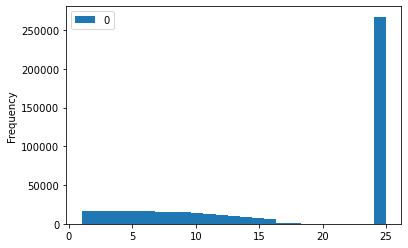

In [16]:
print(pd.DataFrame(y_order.flatten()).plot.hist(bins=25))## ,ylim=(0,1000)

In [17]:
# data split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.01, random_state = 0)
del X, y

In [18]:
print(X_train[0][1])

[-5.0841513e+00  7.0771635e-02 -5.8418870e-01  2.4646287e-01
  1.8285137e+00 -1.1262701e+00  6.5735537e-01  1.5329328e+00
  6.2066919e-01 -6.7069030e-01  1.0873965e+00  1.7795300e-01
 -2.2035263e+00 -5.5455178e-01  1.5312845e+00  1.9849390e+00
 -1.9881687e+00 -4.5285341e-01 -1.1557992e+00  3.0845302e-01
  6.5695131e-01 -1.6801572e+00  1.2509111e-01 -6.3480353e-01
  2.6424465e-01 -1.8350914e+00  1.3959821e+00 -1.1001785e+00
 -2.4194989e+00  2.9623857e+00  1.4317343e+00  1.9310854e-02
  3.4215423e-01  7.4966168e-01 -1.0088371e+00  8.0969352e-01
 -2.5986239e-01 -8.4669787e-01  1.0779321e+00  6.1363038e-02
 -1.5148355e+00 -1.8475902e-03 -8.8226789e-01 -6.8742210e-01
 -2.6793274e-01  1.6574528e+00 -2.0822718e+00 -1.7538213e+00
  4.2922177e+00  1.6022534e+00 -4.4454589e-01 -6.7625672e-01
 -8.8914499e-02 -1.1668312e-01 -3.3394665e-01 -7.5860035e-01
  3.7061727e-01 -6.4284933e-01  3.2509527e-01  4.8748016e-01
  1.5954223e+00  1.4406800e-01 -8.7014019e-01  6.6753399e-01
 -1.0578674e+00  4.23975

In [19]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(19930, 24, 84)
(202, 24, 84)
(19930, 24, 26)
(202, 24, 26)


In [20]:
# def categorical_focal_loss(alpha, gamma):
#     """
#     Softmax version of focal loss.
#     When there is a skew between different categories/labels in your data set, you can try to apply this function as a
#     loss.
#            m
#       FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
#           c=1
#       where m = number of classes, c = class and o = observation
#     Parameters:
#       alpha -- the same as weighing factor in balanced cross entropy. Alpha is used to specify the weight of different
#       categories/labels, the size of the array needs to be consistent with the number of classes.
#       gamma -- focusing parameter for modulating factor (1-p)
#     Default value:
#       gamma -- 2.0 as mentioned in the paper
#       alpha -- 0.25 as mentioned in the paper
#     References:
#         Official paper: https://arxiv.org/pdf/1708.02002.pdf
#         https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
#     Usage:
#      model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)
#     """

#     alpha = np.array(alpha, dtype=np.float32)

#     def categorical_focal_loss_fixed(y_true, y_pred):
#         """
#         :param y_true: A tensor of the same shape as `y_pred`
#         :param y_pred: A tensor resulting from a softmax
#         :return: Output tensor.
#         """

#         # Clip the prediction value to prevent NaN's and Inf's
#         epsilon = K.epsilon()
#         y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

#         # Calculate Cross Entropy
#         cross_entropy = -y_true * K.log(y_pred)

#         # Calculate Focal Loss
#         loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

#         # Compute mean loss in mini_batch
#         return K.mean(K.sum(loss, axis=-1))

#     return categorical_focal_loss_fixed

In [21]:
# creating dataset with batch size
batch_size = 2048 # hyperparameter
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=19930).batch(batch_size)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_dataset = valid_dataset.shuffle(buffer_size=202).batch(batch_size)


del X_train, y_train

In [22]:
# set up parameters
num_layers = 2 # hyperparameter
d_model = max_col # 4*35 84=4*3*7
num_heads = 28 # hyperparameter *must be a factor of d_model*
d_ffn = 256 # hyperparameter
pe_input = 24
target_size = 26
dropout_rate = 0.1 # hyperparameter

In [23]:
# set up model
trans_race = transformer.TransRace(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    d_ffn=d_ffn,
    pe_input=pe_input,
    target_size=target_size,
    rate=dropout_rate,
)
opt = optimizers.Adam(decay=0.01)
loss = categorical_focal_loss(alpha=[alpha], gamma=0.5)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [24]:
trans_race.compile(
    optimizer=opt,
    loss=loss,#'categorical_crossentropy', # 'sigmoid_focal_crossentropy'
    metrics=['accuracy'], #['categorical_accuracy']
)

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='../models/results/transformer.h5',
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True,
)

history = trans_race.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=1000,
    verbose=True, # hide the output because we have so many epochs
    callbacks=[model_checkpoint_callback]
)
print(trans_race.summary())
# trans_race.save_weights("../models/results/transformer.h5")

    def call(self, inputs, training=True):
        inp = inputs

        enc_padding_mask = self.create_masks(inp) #, tar
        # , look_ahead_mask, dec_padding_mask

        enc_output = self.encoder(inp, training, enc_padding_mask)

        final_output = self.final_layer(enc_output)
#         print("final output shape", final_output.shape)

        return final_output

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, inputs, training=True):
        inp = inputs

        enc_padding_mask = self.create_masks(inp) #, tar
        # , look_ahead_mask, dec_padding_mask

        enc_output = self.encoder(inp, training, enc_padding_mask)

        final_output = self.final_layer(enc_output)
#         print("final output shape", final_output.shape)

        return final_output

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x, training, mask):
#         print

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
    def call(self, x, training, mask):
#         pri

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, self.seq_len, self.num_heads, self.depth))
#         print(x.shape,"split_head")
        return tf.transpose(x, perm=[0, 2, 1, 3])

This may be caused by multiline strings or comments not indented at the same level as the code.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 10 steps, validate on 1 steps
Epoch 1/1000
10/10 [==============================] - 10s 964ms/step - loss: 3.6672 - acc: 0.0703 - val_loss: 3.0827 - val_acc: 0.1130
Epoch 2/1000
10/10 [==============================] - 1s 138ms/step - loss: 3.0360 - acc: 0.1149 - val_loss: 2.9339 - val_acc: 0.1300
Epoch 3/1000
10/10 [==============================] - 1s 128ms/step - loss: 2.8293 - acc: 0.1366 - val_loss: 2.5775 - val_ac

10/10 [==============================] - 1s 125ms/step - loss: 2.1018 - acc: 0.5518 - val_loss: 2.1334 - val_acc: 0.5654
Epoch 52/1000
10/10 [==============================] - 1s 122ms/step - loss: 2.0809 - acc: 0.5530 - val_loss: 2.1268 - val_acc: 0.5652
Epoch 53/1000
10/10 [==============================] - 1s 124ms/step - loss: 2.0985 - acc: 0.5531 - val_loss: 2.1252 - val_acc: 0.5660
Epoch 54/1000
10/10 [==============================] - 1s 126ms/step - loss: 2.0893 - acc: 0.5541 - val_loss: 2.1230 - val_acc: 0.5666
Epoch 55/1000
10/10 [==============================] - 1s 125ms/step - loss: 2.0948 - acc: 0.5546 - val_loss: 2.1249 - val_acc: 0.5670
Epoch 56/1000
10/10 [==============================] - 1s 121ms/step - loss: 2.0780 - acc: 0.5542 - val_loss: 2.1238 - val_acc: 0.5668
Epoch 57/1000
10/10 [==============================] - 1s 124ms/step - loss: 2.0823 - acc: 0.5561 - val_loss: 2.1243 - val_acc: 0.5687
Epoch 58/1000
10/10 [==============================] - 1s 122ms/step 

Epoch 112/1000
10/10 [==============================] - 1s 122ms/step - loss: 2.0162 - acc: 0.5718 - val_loss: 2.1252 - val_acc: 0.5778
Epoch 113/1000
10/10 [==============================] - 1s 121ms/step - loss: 2.0673 - acc: 0.5721 - val_loss: 2.1314 - val_acc: 0.5780
Epoch 114/1000
10/10 [==============================] - 1s 122ms/step - loss: 2.0226 - acc: 0.5713 - val_loss: 2.1289 - val_acc: 0.5778
Epoch 115/1000
10/10 [==============================] - 1s 122ms/step - loss: 2.0282 - acc: 0.5726 - val_loss: 2.1260 - val_acc: 0.5778
Epoch 116/1000
10/10 [==============================] - 1s 121ms/step - loss: 2.0152 - acc: 0.5723 - val_loss: 2.1259 - val_acc: 0.5776
Epoch 117/1000
10/10 [==============================] - 1s 121ms/step - loss: 2.0302 - acc: 0.5727 - val_loss: 2.1244 - val_acc: 0.5784
Epoch 118/1000
10/10 [==============================] - 1s 121ms/step - loss: 2.0340 - acc: 0.5725 - val_loss: 2.1212 - val_acc: 0.5780
Epoch 119/1000
10/10 [==========================

10/10 [==============================] - 1s 122ms/step - loss: 2.0173 - acc: 0.5784 - val_loss: 2.0909 - val_acc: 0.5825
Epoch 173/1000
10/10 [==============================] - 1s 122ms/step - loss: 2.0012 - acc: 0.5781 - val_loss: 2.0920 - val_acc: 0.5821
Epoch 174/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9929 - acc: 0.5785 - val_loss: 2.0929 - val_acc: 0.5829
Epoch 175/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9918 - acc: 0.5785 - val_loss: 2.0937 - val_acc: 0.5815
Epoch 176/1000
10/10 [==============================] - 1s 121ms/step - loss: 2.0046 - acc: 0.5785 - val_loss: 2.0963 - val_acc: 0.5819
Epoch 177/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9904 - acc: 0.5784 - val_loss: 2.0967 - val_acc: 0.5821
Epoch 178/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9987 - acc: 0.5785 - val_loss: 2.0960 - val_acc: 0.5815
Epoch 179/1000
10/10 [==============================] - 1s 121m

10/10 [==============================] - 1s 121ms/step - loss: 1.9899 - acc: 0.5815 - val_loss: 2.0905 - val_acc: 0.5858
Epoch 233/1000
10/10 [==============================] - 1s 124ms/step - loss: 1.9776 - acc: 0.5817 - val_loss: 2.0882 - val_acc: 0.5864
Epoch 234/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9731 - acc: 0.5819 - val_loss: 2.0879 - val_acc: 0.5856
Epoch 235/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9790 - acc: 0.5822 - val_loss: 2.0902 - val_acc: 0.5862
Epoch 236/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9784 - acc: 0.5814 - val_loss: 2.0933 - val_acc: 0.5858
Epoch 237/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9862 - acc: 0.5814 - val_loss: 2.0927 - val_acc: 0.5858
Epoch 238/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9790 - acc: 0.5819 - val_loss: 2.0925 - val_acc: 0.5860
Epoch 239/1000
10/10 [==============================] - 1s 121m

10/10 [==============================] - 1s 122ms/step - loss: 1.9746 - acc: 0.5846 - val_loss: 2.0878 - val_acc: 0.5862
Epoch 293/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9660 - acc: 0.5839 - val_loss: 2.0877 - val_acc: 0.5866
Epoch 294/1000
10/10 [==============================] - 1s 123ms/step - loss: 1.9785 - acc: 0.5844 - val_loss: 2.0853 - val_acc: 0.5873
Epoch 295/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9754 - acc: 0.5844 - val_loss: 2.0843 - val_acc: 0.5862
Epoch 296/1000
10/10 [==============================] - 1s 123ms/step - loss: 1.9694 - acc: 0.5843 - val_loss: 2.0843 - val_acc: 0.5860
Epoch 297/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9707 - acc: 0.5845 - val_loss: 2.0853 - val_acc: 0.5856
Epoch 298/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9656 - acc: 0.5840 - val_loss: 2.0860 - val_acc: 0.5856
Epoch 299/1000
10/10 [==============================] - 1s 123m

10/10 [==============================] - 1s 122ms/step - loss: 1.9790 - acc: 0.5860 - val_loss: 2.0808 - val_acc: 0.5864
Epoch 353/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9734 - acc: 0.5858 - val_loss: 2.0801 - val_acc: 0.5864
Epoch 354/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9628 - acc: 0.5860 - val_loss: 2.0799 - val_acc: 0.5866
Epoch 355/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9622 - acc: 0.5855 - val_loss: 2.0779 - val_acc: 0.5866
Epoch 356/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9728 - acc: 0.5860 - val_loss: 2.0757 - val_acc: 0.5862
Epoch 357/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9589 - acc: 0.5857 - val_loss: 2.0751 - val_acc: 0.5864
Epoch 358/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9654 - acc: 0.5865 - val_loss: 2.0759 - val_acc: 0.5862
Epoch 359/1000
10/10 [==============================] - 1s 122m

10/10 [==============================] - 1s 122ms/step - loss: 1.9633 - acc: 0.5877 - val_loss: 2.0756 - val_acc: 0.5864
Epoch 413/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9630 - acc: 0.5870 - val_loss: 2.0734 - val_acc: 0.5868
Epoch 414/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9575 - acc: 0.5871 - val_loss: 2.0729 - val_acc: 0.5868
Epoch 415/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9551 - acc: 0.5871 - val_loss: 2.0732 - val_acc: 0.5868
Epoch 416/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9564 - acc: 0.5873 - val_loss: 2.0741 - val_acc: 0.5870
Epoch 417/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9588 - acc: 0.5873 - val_loss: 2.0745 - val_acc: 0.5870
Epoch 418/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9487 - acc: 0.5870 - val_loss: 2.0747 - val_acc: 0.5860
Epoch 419/1000
10/10 [==============================] - 1s 123m

10/10 [==============================] - 1s 123ms/step - loss: 1.9465 - acc: 0.5888 - val_loss: 2.0774 - val_acc: 0.5873
Epoch 473/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9632 - acc: 0.5879 - val_loss: 2.0778 - val_acc: 0.5875
Epoch 474/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9534 - acc: 0.5881 - val_loss: 2.0778 - val_acc: 0.5875
Epoch 475/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9507 - acc: 0.5881 - val_loss: 2.0776 - val_acc: 0.5875
Epoch 476/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9644 - acc: 0.5882 - val_loss: 2.0779 - val_acc: 0.5875
Epoch 477/1000
10/10 [==============================] - 1s 124ms/step - loss: 1.9474 - acc: 0.5883 - val_loss: 2.0777 - val_acc: 0.5879
Epoch 478/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9485 - acc: 0.5883 - val_loss: 2.0768 - val_acc: 0.5873
Epoch 479/1000
10/10 [==============================] - 1s 121m

10/10 [==============================] - 1s 122ms/step - loss: 1.9400 - acc: 0.5888 - val_loss: 2.0742 - val_acc: 0.5868
Epoch 533/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9460 - acc: 0.5888 - val_loss: 2.0740 - val_acc: 0.5870
Epoch 534/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9459 - acc: 0.5892 - val_loss: 2.0741 - val_acc: 0.5870
Epoch 535/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9473 - acc: 0.5896 - val_loss: 2.0741 - val_acc: 0.5868
Epoch 536/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9481 - acc: 0.5895 - val_loss: 2.0728 - val_acc: 0.5868
Epoch 537/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9494 - acc: 0.5892 - val_loss: 2.0728 - val_acc: 0.5870
Epoch 538/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9428 - acc: 0.5895 - val_loss: 2.0736 - val_acc: 0.5875
Epoch 539/1000
10/10 [==============================] - 1s 126m

10/10 [==============================] - 1s 122ms/step - loss: 1.9447 - acc: 0.5897 - val_loss: 2.0711 - val_acc: 0.5862
Epoch 593/1000
10/10 [==============================] - 1s 124ms/step - loss: 1.9504 - acc: 0.5899 - val_loss: 2.0712 - val_acc: 0.5866
Epoch 594/1000
10/10 [==============================] - 1s 123ms/step - loss: 1.9430 - acc: 0.5900 - val_loss: 2.0697 - val_acc: 0.5873
Epoch 595/1000
10/10 [==============================] - 1s 120ms/step - loss: 1.9432 - acc: 0.5893 - val_loss: 2.0687 - val_acc: 0.5875
Epoch 596/1000
10/10 [==============================] - 1s 120ms/step - loss: 1.9473 - acc: 0.5902 - val_loss: 2.0672 - val_acc: 0.5870
Epoch 597/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9431 - acc: 0.5898 - val_loss: 2.0667 - val_acc: 0.5862
Epoch 598/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9482 - acc: 0.5903 - val_loss: 2.0667 - val_acc: 0.5862
Epoch 599/1000
10/10 [==============================] - 1s 121m

10/10 [==============================] - 1s 123ms/step - loss: 1.9395 - acc: 0.5905 - val_loss: 2.0667 - val_acc: 0.5877
Epoch 653/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9423 - acc: 0.5904 - val_loss: 2.0666 - val_acc: 0.5877
Epoch 654/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9409 - acc: 0.5909 - val_loss: 2.0671 - val_acc: 0.5877
Epoch 655/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9458 - acc: 0.5910 - val_loss: 2.0676 - val_acc: 0.5879
Epoch 656/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9392 - acc: 0.5901 - val_loss: 2.0667 - val_acc: 0.5881
Epoch 657/1000
10/10 [==============================] - 1s 126ms/step - loss: 1.9541 - acc: 0.5913 - val_loss: 2.0658 - val_acc: 0.5881
Epoch 658/1000
10/10 [==============================] - 1s 124ms/step - loss: 1.9408 - acc: 0.5902 - val_loss: 2.0624 - val_acc: 0.5881
Epoch 659/1000
10/10 [==============================] - 1s 123m

10/10 [==============================] - 1s 125ms/step - loss: 1.9345 - acc: 0.5905 - val_loss: 2.0617 - val_acc: 0.5879
Epoch 713/1000
10/10 [==============================] - 1s 125ms/step - loss: 1.9400 - acc: 0.5906 - val_loss: 2.0615 - val_acc: 0.5885
Epoch 714/1000
10/10 [==============================] - 1s 124ms/step - loss: 1.9355 - acc: 0.5914 - val_loss: 2.0610 - val_acc: 0.5879
Epoch 715/1000
10/10 [==============================] - 1s 123ms/step - loss: 1.9366 - acc: 0.5915 - val_loss: 2.0606 - val_acc: 0.5879
Epoch 716/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9365 - acc: 0.5912 - val_loss: 2.0604 - val_acc: 0.5877
Epoch 717/1000
10/10 [==============================] - 1s 123ms/step - loss: 1.9398 - acc: 0.5916 - val_loss: 2.0609 - val_acc: 0.5877
Epoch 718/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9393 - acc: 0.5914 - val_loss: 2.0609 - val_acc: 0.5879
Epoch 719/1000
10/10 [==============================] - 1s 121m

10/10 [==============================] - 1s 121ms/step - loss: 1.9370 - acc: 0.5921 - val_loss: 2.0585 - val_acc: 0.5866
Epoch 773/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9314 - acc: 0.5917 - val_loss: 2.0581 - val_acc: 0.5870
Epoch 774/1000
10/10 [==============================] - 1s 124ms/step - loss: 1.9452 - acc: 0.5917 - val_loss: 2.0579 - val_acc: 0.5866
Epoch 775/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9352 - acc: 0.5920 - val_loss: 2.0582 - val_acc: 0.5864
Epoch 776/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9369 - acc: 0.5919 - val_loss: 2.0592 - val_acc: 0.5864
Epoch 777/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9323 - acc: 0.5913 - val_loss: 2.0596 - val_acc: 0.5868
Epoch 778/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9490 - acc: 0.5917 - val_loss: 2.0592 - val_acc: 0.5866
Epoch 779/1000
10/10 [==============================] - 1s 121m

10/10 [==============================] - 1s 123ms/step - loss: 1.9393 - acc: 0.5924 - val_loss: 2.0554 - val_acc: 0.5873
Epoch 833/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9307 - acc: 0.5918 - val_loss: 2.0564 - val_acc: 0.5870
Epoch 834/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9319 - acc: 0.5926 - val_loss: 2.0569 - val_acc: 0.5870
Epoch 835/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9330 - acc: 0.5915 - val_loss: 2.0577 - val_acc: 0.5868
Epoch 836/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9333 - acc: 0.5919 - val_loss: 2.0583 - val_acc: 0.5870
Epoch 837/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9364 - acc: 0.5920 - val_loss: 2.0589 - val_acc: 0.5870
Epoch 838/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9331 - acc: 0.5922 - val_loss: 2.0592 - val_acc: 0.5870
Epoch 839/1000
10/10 [==============================] - 1s 122m

10/10 [==============================] - 1s 123ms/step - loss: 1.9341 - acc: 0.5927 - val_loss: 2.0609 - val_acc: 0.5883
Epoch 893/1000
10/10 [==============================] - 1s 123ms/step - loss: 1.9467 - acc: 0.5923 - val_loss: 2.0596 - val_acc: 0.5881
Epoch 894/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9313 - acc: 0.5923 - val_loss: 2.0591 - val_acc: 0.5879
Epoch 895/1000
10/10 [==============================] - 1s 124ms/step - loss: 1.9347 - acc: 0.5922 - val_loss: 2.0593 - val_acc: 0.5879
Epoch 896/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9337 - acc: 0.5925 - val_loss: 2.0596 - val_acc: 0.5881
Epoch 897/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9355 - acc: 0.5926 - val_loss: 2.0595 - val_acc: 0.5877
Epoch 898/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9338 - acc: 0.5927 - val_loss: 2.0598 - val_acc: 0.5875
Epoch 899/1000
10/10 [==============================] - 1s 122m

10/10 [==============================] - 1s 121ms/step - loss: 1.9366 - acc: 0.5924 - val_loss: 2.0591 - val_acc: 0.5883
Epoch 953/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9299 - acc: 0.5934 - val_loss: 2.0592 - val_acc: 0.5881
Epoch 954/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9263 - acc: 0.5926 - val_loss: 2.0596 - val_acc: 0.5881
Epoch 955/1000
10/10 [==============================] - 1s 122ms/step - loss: 1.9259 - acc: 0.5925 - val_loss: 2.0600 - val_acc: 0.5881
Epoch 956/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9291 - acc: 0.5930 - val_loss: 2.0601 - val_acc: 0.5885
Epoch 957/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9318 - acc: 0.5932 - val_loss: 2.0601 - val_acc: 0.5885
Epoch 958/1000
10/10 [==============================] - 1s 121ms/step - loss: 1.9266 - acc: 0.5925 - val_loss: 2.0594 - val_acc: 0.5883
Epoch 959/1000
10/10 [==============================] - 1s 123m

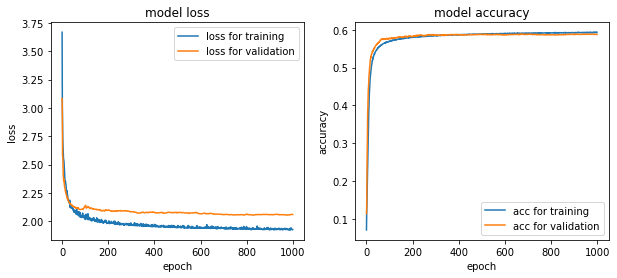

In [25]:
# plot 
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
# for loss
axL.plot(history.history['loss'],label="loss for training")
axL.plot(history.history['val_loss'],label="loss for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')
axR.plot(history.history['acc'],label="acc for training")
axR.plot(history.history['val_acc'],label="acc for validation")
axR.set_title('model accuracy')
axR.set_xlabel('epoch')
axR.set_ylabel('accuracy')
axR.legend(loc='lower right')
# figureの保存
# plt.savefig("../models/results/trans_race_result.png")

In [47]:
# predict

preds = trans_race.predict(X_valid)
y_pred = np.argmax(preds, axis = 2)
y_ans = np.argmax(y_valid, axis = 2)


In [48]:
# def order_algorithm(preds):
#     num_race = preds.shape[0]
#     y_preds = np.full((num_race, 24), 25)
#     for i in range(num_race):
#         one_race = preds[i,:,:]
#         init_preds = np.argmax(one_race, axis = -1)
#         exist_horse = np.delete(one_race, np.where(init_preds == 25)[0], 0)
#         for j in range(1,exist_horse.shape[0]+1):
#             one_order = np.argmax(exist_horse[:,j])
#             for k in range(one_race.shape[0]):
#                 if np.array_equal(one_race[k], exist_horse[one_order]):
#                     y_preds[i][k] = j
#                     exist_horse = np.delete(exist_horse, one_order, 0)
#                     break
#     return y_preds

In [49]:
# print(pd.DataFrame(preds[0]))

In [50]:
# def order_algorithm(preds):
#     num_race = preds.shape[0]
#     y_preds = np.full((num_race, 24), 25)
#     for i in range(num_race): # iterate all race
#         one_race = preds[i,:,:] # shape = (24, 26) ,so (num of horse, num of target 0-25)
#         init_preds = np.argmax(one_race, axis = -1)
#         exist_horse = np.delete(one_race, np.where(init_preds == 25)[0], 0) # shape = (num of exist horse, 26)
#         for j in range(1,exist_horse.shape[0]+1): # iterate 1-num of exist horse
#             one_order = np.argmax(exist_horse[:,j]) # this is a target order
#             for k in range(one_race.shape[0]): # search the horse k = (0, 23)
#                 if np.array_equal(one_race[k], exist_horse[one_order]):
#                     y_preds[i][k] = j
#                     exist_horse = np.delete(exist_horse, one_order, 0)
#                     exist_horse[:,j+1] += exist_horse[:,j]
#                     one_race[:,j+1] += one_race[:,j]
#                     break
#     return y_preds

In [51]:
y_preds = order_algorithm(preds)
print(y_preds.shape)
print(y_preds[0])

(202, 24)
[ 5  4  8  7  3  1  2  6  9 10 25 25 25 25 25 25 25 25 25 25 25 25 25 25]


In [52]:
print(preds.shape)
print(y_preds.shape)
print(y_ans.shape)


(202, 24, 26)
(202, 24)
(202, 24)


In [53]:
print(y_ans[0])
print(y_preds[0])
print(y_pred[0])
# print(np.mean(y_pred))

[11  4  5 12  8  1  2  9  6 10 25 25 25 25 25 25 25 25 25 25 25 25 25 25]
[ 5  4  8  7  3  1  2  6  9 10 25 25 25 25 25 25 25 25 25 25 25 25 25 25]
[ 1  1  6  8  3  2  6  5 10  6 25 25 25 25 25 25 25 25 25 25 25 25 25 25]


In [54]:
correct = 0
for i in range(y_preds.shape[0]):
    for j in range(y_preds.shape[1]):
        if (y_preds[i][j] == y_ans[i][j]):
            correct += 1
accuracy = correct / len(y_pred)
print("accuracy: ", accuracy)

accuracy:  13.450495049504951


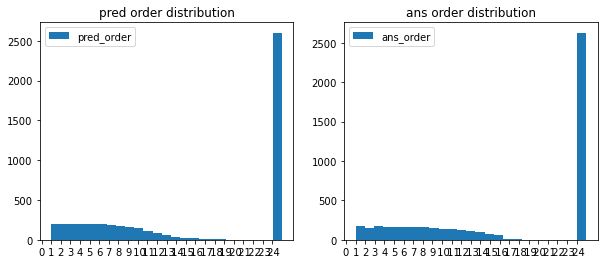

In [55]:
# the distribution of prediction
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
label = ['0','1','2','3','4','5','6','7','8','9',' 10',' 11',' 12',' 13',' 14',' 15',' 16',' 17',' 18',' 19',' 20',' 21',' 22',' 23',' 24']

axL.hist(y_preds.flatten(), bins = 25, label = "pred_order")##, range = (1,21)
axL.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
axL.set_xticklabels(label)
axL.set_title('pred order distribution')
axL.legend()
axR.hist(y_ans.flatten(), bins = 25, label = "ans_order")##, range = (1,21)
axR.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
axR.set_xticklabels(label)
axR.set_title('ans order distribution')
axR.legend()
fig.show()


In [64]:
# precision = TP / (TP + FP)
# the accuracy of predected True
i = 0
correct_first = 0
all_f = 0
increase = 0
# X_valid_inv = standard_scale.inverse_transform(X_valid)
# X_valid_inv_df = pd.DataFrame(X_valid_inv)
# odds = X_test_inv_df['odds'].values
# hit_odds = []
# select = []

for i in range(y_preds.shape[0]):
    for j in range(y_preds.shape[1]):
        if (y_preds[i][j] == 1):  # total nubber of predicted 1st (TP + FP)  & (pred[i][1]*odds[i] > 1.0)) | (pred[i][1]> 0.25)
            all_f += 1
            if (y_ans[i][j] == 1) or (y_ans[i][j] == 2) or (y_ans[i][j] == 3):
                correct_first += 1   #　True Positive
            
# for i in range(len(y_ans)):
#     if (y_preds[i] == 1):  # total nubber of predicted 1st (TP + FP)  & (pred[i][1]*odds[i] > 1.0)) | (pred[i][1]> 0.25)
#         all_f = all_f + 1
#         if (y_ans[i] == 1):
#             correct_first = correct_first + 1   #　True Positive
# #             increase += odds[i]
# #             hit_odds.append(odds[i])
            
            
            
print("all_f: ", all_f)
print("correct_first: ", correct_first)
# print("hit odds average: ", np.array(hit_odds).mean())
# print("spent money:", all_f * 100)
# revenue = (increase - all_f) * 100
# retrive = increase / all_f
 
# print("retrive rate: ", retrive) 
# print("revenue: ", revenue)
precision = correct_first / all_f
print("precision: ",precision)
#print("\n".join(map(str,hit_odds)))
# print("min: ", min(hit_odds))
# print("mid: ", np.median(np.array(hit_odds)))
# print("max: ", max(hit_odds))

# fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

# axL.hist(hit_odds, bins = 50, label = "hit_odds")
# axL.set_title('hit odds distribution')
# axL.legend()
# axR.hist(odds, bins = 50, label = "odds", range = (0,40))
# axR.set_title('all odds distribution')
# axR.legend()
# fig.show()


all_f:  202
correct_first:  83
precision:  0.41089108910891087


In [59]:
# Recall = TP / (TP + FN)
# the accuracy of label True
i = 0
correct_first = 0
all_f = 0
# odds_f = []
p_rate_f = []

# all_f_odds = []

for i in range(y_preds.shape[0]):
    for j in range(y_preds.shape[1]):
        if (y_ans[i][j] == 1):  # total nubber of predicted 1st (TP + FP)  & (pred[i][1]*odds[i] > 1.0)) | (pred[i][1]> 0.25)
            all_f += 1
            if (y_preds[i][j] == 1):
                correct_first += 1   #　True Positive
                
                
# for i in range(len(y_ans)):
#     if (y_ans[i] == 1):  # TP + FN
#         all_f = all_f + 1
# #         all_f_odds.append(odds[i])
#         if (y_preds[i] == 1):
#             correct_first = correct_first + 1   #　TP
#             odds_f.append(odds[i])
#             p_rate_f.append(pred[i][1])

# fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

# axL.scatter(p_rate_f, odds_f)  
# axL.set_title('correlation odss and prediction')
# #axL.xlabel('prediction rate first')
# #axL.ylabel('odds')
# axR.hist(odds_f, bins = 50, label = "odds")
# axR.set_title('all first odds distribution')
# axR.legend()

# fig.show()
Recall = correct_first / all_f
print("Recall: ",Recall)
# print("all_f_odds average: ", np.array(all_f_odds).mean())



Recall:  0.2138728323699422


In [67]:
# 3 renpuku
within_3 = 0
hit = 0

for i in range(y_preds.shape[0]):
    for j in range(y_preds.shape[1]):
        within_3 += 1
        if (y_ans[i][j] == 1) or (y_ans[i][j] == 2) or (y_ans[i][j] == 3):  # total nubber of predicted 1st (TP + FP)  & (pred[i][1]*odds[i] > 1.0)) | (pred[i][1]> 0.25)
            if (y_preds[i][j] == 1) or (y_preds[i][j] == 2) or (y_preds[i][j] == 3) or (y_preds[i][j] == 4):
                hit += 1   #　True Positive
                
precision = hit / within_3
print("precision of 3 renpuku: ", precision)

precision of 3 renpuku:  0.0558993399339934
